In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pysd
from SALib.sample import saltelli
from SALib.analyze import sobol
import scipy as sp

# Load Calibration data

In [4]:
data = pd.read_csv("/Users/adenooy/Library/CloudStorage/OneDrive-Personal/UVA/Thesis/MSc-Thesis/data/dynamic/calibration_incidence.csv", sep=',',decimal='.')
data=data.drop("Unnamed: 0",axis=1)
data.head(23)


,year,var,Lower,Mean,Upper,Lower_cumulative,Mean_cumulative,Upper_cumulative
0,2000,e_inc_num,56000,139000,259000,56000,139000,259000
1,2001,e_inc_num,57000,159000,312000,113000,298000,571000
2,2002,e_inc_num,57000,175000,357000,170000,473000,928000
3,2003,e_inc_num,54000,206000,456000,224000,679000,1384000
4,2004,e_inc_num,54000,221000,501000,278000,900000,1885000
5,2005,e_inc_num,56000,226000,510000,334000,1126000,2395000
6,2006,e_inc_num,56000,239000,549000,390000,1365000,2944000
7,2007,e_inc_num,60000,235000,525000,450000,1600000,3469000
8,2008,e_inc_num,66000,221000,467000,516000,1821000,3936000
9,2009,e_inc_num,68000,228000,483000,584000,2049000,4419000


Text(0.5, 1.0, 'Estimated Incident cases of TB')

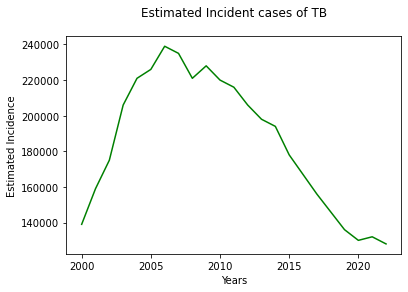

In [5]:
plt.plot(data["year"], data['Mean'],label="mean_estimate",color="green")
#plt=dataSoil.plot(x="days",y="bacteria_measured")
plt.xlabel('Years')
plt.ylabel('Estimated Incidence')
plt.title("Estimated Incident cases of TB",pad=20)

Text(0.5, 1.0, 'Estimated Cumulative Incident cases of TB')

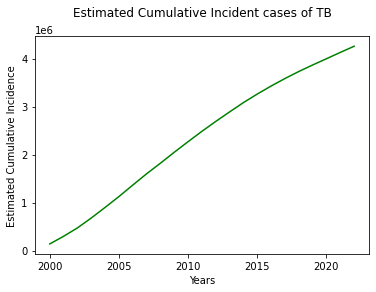

In [6]:
plt.plot(data["year"], data['Mean_cumulative'],label="mean_estimate",color="green")
#plt=dataSoil.plot(x="days",y="bacteria_measured")
plt.xlabel('Years')
plt.ylabel('Estimated Cumulative Incidence')
plt.title("Estimated Cumulative Incident cases of TB",pad=20)

# Load Model

In [98]:
model = pysd.read_vensim("/Users/adenooy/Library/CloudStorage/OneDrive-Personal/UVA/Thesis/MSc-Thesis/model/transmission/V9_years_cummulative.mdl")

In [99]:
model_output = model.run()


<AxesSubplot:>

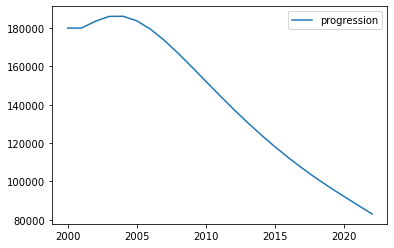

In [100]:
model_output.plot(y="progression")

## Calibration

In [101]:
#Set up observable and claibration parameters
observable = "progression"
parameter1 = 'transmission rate'
parameter2 = 'relapse rate'
parameter3 = 'initial incident'
parameter4="progression rate"
parameter5 = 'initial latent'
parameter6 = 'progression time'




def error(param_list):
    #unpack the parameter list
    parameter1_value,parameter2_value,parameter3_value,parameter4_value,parameter5_value,parameter6_value = param_list
    #run the model with the new parameters, returning the info we're interested in
    result = model.run(params={'transmission rate':parameter1_value,
                               'relapse rate':parameter2_value,
                               'initial incident': parameter3_value,
                               "progression rate":parameter4_value,
                               'initial latent': parameter5_value,
                               'progression time': parameter6_value
                              },
                       return_columns=['progression'])
    #print(result['progression'] -data['Mean'])
    
    result=result.reset_index(drop=True)
    #print(result)
    calDat=data.reset_index(drop=True)
    calDat=calDat["Mean"]
    
    error=sum((result['progression'] - calDat)**2)
    #print(error)
    #return the sum of the squared errors
    return  error

In [102]:
parameter1_guess = 0.05
parameter1_bounds = (0.0, 1)

parameter2_guess = 0.1
parameter2_bounds = (0.004, 0.1)

parameter3_guess = 100000
parameter3_bounds = (1, 3000000)

parameter4_guess = 0.08
parameter4_bounds = (0, 0.2)


parameter5_guess = 100000
parameter5_bounds = (1, 3000000)

parameter6_guess = 2
parameter6_bounds = (1,5)



res = sp.optimize.minimize(error,
                           x0=[parameter1_guess,parameter2_guess,parameter3_guess,parameter4_guess,parameter5_guess,parameter6_guess],
                           method='L-BFGS-B',
                           bounds=[parameter1_bounds,parameter2_bounds,parameter3_bounds,parameter4_bounds,parameter5_bounds,parameter6_bounds])
res

      fun: 864111296.8168403
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 7.74004460e+06,  2.62454656e+10, -5.72952381e+02,  2.55163908e+06,
        9.88279070e+02, -1.64642335e+06])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 455
      nit: 50
     njev: 65
   status: 0
  success: True
        x: array([3.43474524e-01, 4.00000000e-03, 2.52664038e+06, 1.17069522e-01,
       1.32048035e+06, 3.46686687e+00])

In [103]:
p1, p2, p3,p4,p5,p6= res.x
result = model.run(params=
                   {
                       'transmission rate':p1,
                               'relapse rate':p2,
                               'initial incident': p3,
                               "progression rate":p4,
                       'initial latent': p5,
                       'progression time': p6
                   },
                   return_columns=['progression'])

result

,progression
2000,154588.003731
2001,154588.003731
2002,175311.410951
2003,198685.639435
2004,217481.403663
2005,229667.667063
2006,235527.458954
2007,236206.519181
2008,233019.442061
2009,227151.629304


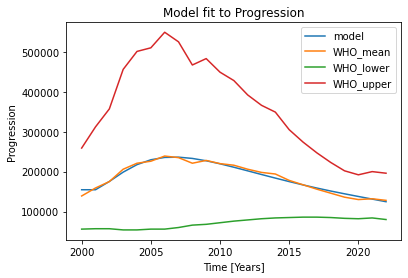

In [104]:
plt.plot(result.index, result['progression'],label="model")
plt.plot(data["year"], data['Mean'], label='WHO_mean');
plt.plot(data["year"], data['Lower'], label='WHO_lower');
plt.plot(data["year"], data['Upper'], label='WHO_upper');
plt.xlabel('Time [Years]')
plt.ylabel('Progression')
plt.title('Model fit to Progression')
plt.legend(loc='upper right')
#plt.text(30,750000000, 'RMSE: 7.39% of Max', color='r', fontsize=12)

## Explore Calibrated

In [112]:
model_cal = pysd.read_vensim("/Users/adenooy/Library/CloudStorage/OneDrive-Personal/UVA/Thesis/MSc-Thesis/model/transmission/V9_years_cummulative_cal.mdl")

In [113]:
model_cal_output = model_cal.run()
display(model_cal_output)

,FINAL TIME,INITIAL TIME,SAVEPER,TIME STEP,Detection,Cumulative Cases,progression,Relapse,CDR,CFR,...,total pop,general mortality,infection,initial incident,initial latent,Latent TB infection,Detected and Treated TB,relapse rate,transmission rate,progression rate
2000,2022,2000,1,1,1.150000e+06,0.000000e+00,154440.000000,220.000000,0.4600,0.450,...,3.805500e+07,0.008,771082.117987,2500000.0,1320000.0,1.320000e+06,5.500000e+04,0.004,0.3434,0.117
2001,2022,2000,1,1,6.398186e+05,1.544400e+05,154440.000000,4817.360000,0.4600,0.450,...,3.872235e+07,0.008,421868.060033,2500000.0,1320000.0,1.926082e+06,1.204340e+06,0.004,0.3434,0.117
2002,2022,2000,1,1,3.896487e+05,3.088800e+05,174887.407095,7318.826080,0.4600,0.450,...,3.944464e+07,0.008,255079.373359,2500000.0,1320000.0,2.178102e+06,1.829707e+06,0.004,0.3434,0.117
2003,2022,2000,1,1,2.764961e+05,4.837674e+05,197941.176089,8789.594900,0.4600,0.450,...,4.020177e+07,0.008,180536.558535,2500000.0,1320000.0,2.240869e+06,2.197399e+06,0.004,0.3434,0.117
2004,2022,2000,1,1,2.318235e+05,6.817086e+05,216464.953167,9790.104326,0.4600,0.450,...,4.098326e+07,0.008,151284.541342,2500000.0,1320000.0,2.205537e+06,2.447526e+06,0.004,0.3434,0.117
2005,2022,2000,1,1,2.187140e+05,8.981735e+05,228455.405443,10599.917060,0.4600,0.450,...,4.178403e+07,0.008,142767.151045,2500000.0,1320000.0,2.122712e+06,2.649979e+06,0.004,0.3434,0.117
2006,2022,2000,1,1,2.181195e+05,1.126629e+06,234194.143996,11347.574237,0.4600,0.450,...,4.260188e+07,0.008,142454.656444,2500000.0,1320000.0,2.020042e+06,2.836894e+06,0.004,0.3434,0.117
2007,2022,2000,1,1,2.208093e+05,1.360823e+06,234814.334936,12083.881521,0.4600,0.450,...,4.343613e+07,0.008,144296.252933,2500000.0,1320000.0,1.912143e+06,3.020970e+06,0.004,0.3434,0.117
2008,2022,2000,1,1,2.227634e+05,1.595637e+06,231615.474343,12822.112162,0.4600,0.435,...,4.428686e+07,0.008,145659.692265,2500000.0,1320000.0,1.806327e+06,3.205528e+06,0.004,0.3434,0.117
2009,2022,2000,1,1,2.228762e+05,1.827253e+06,225769.116492,13559.300340,0.4600,0.420,...,4.515504e+07,0.008,145820.473102,2500000.0,1320000.0,1.705921e+06,3.389825e+06,0.004,0.3434,0.117


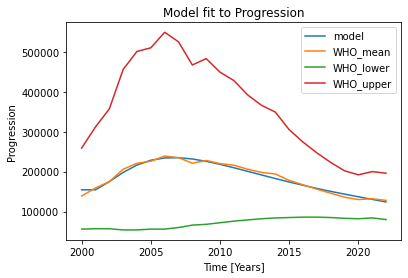

In [114]:
plt.plot(model_cal_output.index, model_cal_output['progression'],label="model")
plt.plot(data["year"], data['Mean'], label='WHO_mean');
plt.plot(data["year"], data['Lower'], label='WHO_lower');
plt.plot(data["year"], data['Upper'], label='WHO_upper');
plt.xlabel('Time [Years]')
plt.ylabel('Progression')
plt.title('Model fit to Progression')
plt.legend(loc='upper right')
#plt.text(30,750000000, 'RMSE: 7.39% of Max', color='r', fontsize=12)

In [115]:
data['Mean']


0     139000
1     159000
2     175000
3     206000
4     221000
5     226000
6     239000
7     235000
8     221000
9     228000
10    220000
11    216000
12    206000
13    198000
14    194000
15    178000
16    167000
17    156000
18    146000
19    136000
20    130000
21    132000
22    128000
Name: Mean, dtype: int64